/opt/anaconda3/envs/gym/lib/python3.12/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment FrozenLake-v3 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/gym/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Percent of successful episodes: 0.432%


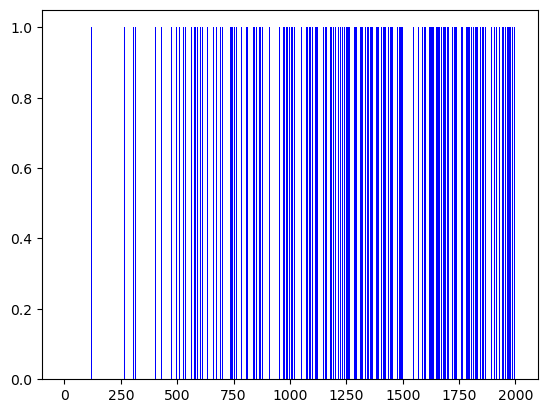

In [3]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym.envs.registration import register

def one_hot(x):
    return np.identity(16, dtype=np.float32)[int(x)].reshape(1, -1)

register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={
        'map_name': '4x4',
        'is_slippery': True
    }
)

env = gym.make('FrozenLake-v3')

input_size = env.observation_space.n
output_size = env.action_space.n
learning_rate = 0.1

W = tf.Variable(tf.random.uniform([input_size, output_size], minval=0, maxval=0.01))

def predict(X):
    return tf.matmul(X, W)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

dis = 0.99
num_episodes = 2000
rList = []

for i in range(num_episodes):
    s = env.reset()[0]
    e = 1. / ((i / 50) + 10)
    rAll = 0
    done = False

    while not done:
        Qs = predict(one_hot(s)).numpy()

        if np.random.rand(1) < e:
            a = env.action_space.sample()
        else:
            a = np.argmax(Qs)

        s1, reward, done, _, _ = env.step(a)

        if done:
            Qs[0, a] = reward
        else:
            Qs1 = predict(one_hot(s1)).numpy()
            Qs[0, a] = reward + dis * np.max(Qs1)

        with tf.GradientTape() as tape:
            Y = Qs
            loss = tf.reduce_sum(tf.square(Y - predict(one_hot(s))))
        
        grads = tape.gradient(loss, [W])
        optimizer.apply_gradients(zip(grads, [W]))

        rAll += reward
        s = s1

    rList.append(rAll)

print("Percent of successful episodes: " + str(sum(rList) / num_episodes) + "%")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()

In [2]:
'''
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym.envs.registration import register

def one_hot(x):
    return np.identity(16)[x:x+1]

register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={
        'map_name': '4x4',
        'is_slippery': True
    }
)

env = gym.make('FrozenLake-v3')

input_size = env.observation_space.n
output_size = env.action_space.n
learning_rate = 0.1

X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))

Qpred = tf.matmul(X, W)
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)

loss = tf.reduce_sum(tf.square(Y - Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

dis = .99
num_episodes = 2000
rList = []

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for i in range(num_episodes):
        s = env.reset()
        e = 1. / ((i/50) + 10)
        rAll = 0
        done = False
        local_loss = []

        while not done:
            Qs = sess.run(Qpred, feed_dict = {X: one_hot(s)})

            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

        s1, reward, done, truncated, info = env.step(a)

        if done:
            Qs[0, a] = reward
        else:
            Qs1 = sess.run(Qpred, feed_dict = {X: one_hot(s1)})
            Qs[0, a] = reward + dis + np.max(Qs1)

        sess.run(train, feed_dict={X: one_hot(s), Y:Qs})

        rAll += reward
        s = s1
    rList.append(rAll)

print("Percent of successful episodes: " + str(sum(rList)/num_episodes) + "%")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()
'''

AttributeError: module 'tensorflow' has no attribute 'placeholder'